#### na wybranym przez siebie zbiorze danych prosze przprowadzic pelna anlize tj. etapy

- **opis projektu**: jaki jest problem, rodzaj uczenia, zawartość danych, zbiory do kilku/nastu MB załączyć, dla innych podać URL
- **analiza wstępna**: statystyka, wizualizacja, wartości odstające, wartości brakujące, kontrola niezrównoważenia, transformacje, inżynieria cech (ekstrakcja nowych, selekcja, redukcja wymiarowości), wybór reprezentacji, ...
- **budowanie modelu**: podział(y) zbioru do procesu uczenia, wybór przynajmniej 5 modeli, dla każdego: wybór hiperparametrów, trenowanie wraz z wizualizacją funkcji straty oraz wybranych metryk, kontrola przeuczenia
- **optymalizacja**: testowanie, wizualizacja macierzy błędu i krzywej ROC, porównanie jakości modeli ze sobą, optymalizacja hiperparametrów modeli, ostateczna analiza


# Przewidywanie Wyników Uczniów

## 1. Opis Projektu

### Problem
Celem projektu jest przewidywanie wyników akademickich uczniów na podstawie czynników demograficznych, społeczno-ekonomicznych, behawioralnych oraz kontekstu szkolnego. Jest to problem **regresji wielowyjściowej** - przewidujemy trzy zmienne docelowe: wyniki z matematyki, czytania i nauk ścisłych. Link: https://www.kaggle.com/datasets/neuralsorcerer/student-performance

### Rodzaj Uczenia
- **Uczenie nadzorowane** (supervised learning)
- **Regresja wielowyjściowa** (multi-output regression)
- Zmienne docelowe: TestScore_Math, TestScore_Reading, TestScore_Science (0-100 punktów)

### Zawartość Danych
Dataset zawiera syntetyczne dane dotyczące wyników uczniów szkół średnich:
- **Zbiór treningowy**: 8,000,774 rekordów (~1.23 GB)
- **Zbiór walidacyjny**: 999,229 rekordów (~158 MB)  
- **Zbiór testowy**: 999,997 rekordów (~158 MB)
- **Łącznie**: ~10M rekordów z 21 cechami

> W analizie użyłem fragmentu danych ze względu na ograniczenia sprzętowe.

### Cechy Wejściowe
- **Demograficzne**: Age, Grade, Gender, Race
- **Społeczno-ekonomiczne**: SES_Quartile, ParentalEducation, SchoolType, Locale
- **Akademickie**: GPA, AttendanceRate, StudyHours
- **Techniczne**: InternetAccess
- **Behawioralne**: Extracurricular, PartTimeJob, ParentSupport, Romantic, FreeTime, GoOut


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

# Konfiguracja wykresów
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Analiza Wstępna

### Wczytanie i Podstawowe Informacje o Danych

In [61]:
# próbka losowo wybranych 15000 rzędów
sample_size = 15000
train_df = pd.read_csv('data/train.csv').sample(n=sample_size, random_state=42)
val_df = pd.read_csv('data/validation.csv').sample(n=int(sample_size * 0.125), random_state=42)
test_df = pd.read_csv('data/test.csv').sample(n=int(sample_size * 0.125), random_state=42)

print("Kształt zbiorów:")
print(f"Treningowy: {train_df.shape}")
print(f"Walidacyjny: {val_df.shape}")
print(f"Testowy: {test_df.shape}")

# Podstawowe informacje
print("\nPodstawowe informacje o danych:")
print(train_df.info())
print("\nStatystyki opisowe:")
print(train_df.describe())

Kształt zbiorów:
Treningowy: (15000, 21)
Walidacyjny: (1875, 21)
Testowy: (1875, 21)

Podstawowe informacje o danych:
<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 7836724 to 2075706
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                15000 non-null  int64  
 1   Grade              15000 non-null  int64  
 2   Gender             15000 non-null  object 
 3   Race               15000 non-null  object 
 4   SES_Quartile       15000 non-null  int64  
 5   ParentalEducation  15000 non-null  object 
 6   SchoolType         15000 non-null  object 
 7   Locale             15000 non-null  object 
 8   TestScore_Math     15000 non-null  float64
 9   TestScore_Reading  15000 non-null  float64
 10  TestScore_Science  15000 non-null  float64
 11  GPA                15000 non-null  float64
 12  AttendanceRate     15000 non-null  float64
 13  StudyHours         15000 non-null  float64
 1

### Analiza Brakujących Wartości

In [62]:
# Sprawdzenie brakujących wartości
missing_data = train_df.isnull().sum()
missing_percent = 100 * missing_data / len(train_df)

plt.figure(figsize=(12, 6))
missing_df = pd.DataFrame({'Kolumna': missing_data.index,
                           'Brakujące': missing_data.values,
                           'Procent': missing_percent.values})
missing_df = missing_df[missing_df['Brakujące'] > 0].sort_values('Brakujące', ascending=False)

if len(missing_df) > 0:
    sns.barplot(data=missing_df, x='Procent', y='Kolumna')
    plt.title('Procent Brakujących Wartości')
    plt.xlabel('Procent (%)')
else:
    print("Brak brakujących wartości w danych!")
plt.show()

Brak brakujących wartości w danych!


<Figure size 1200x600 with 0 Axes>

### Rozkład Zmiennych Docelowych

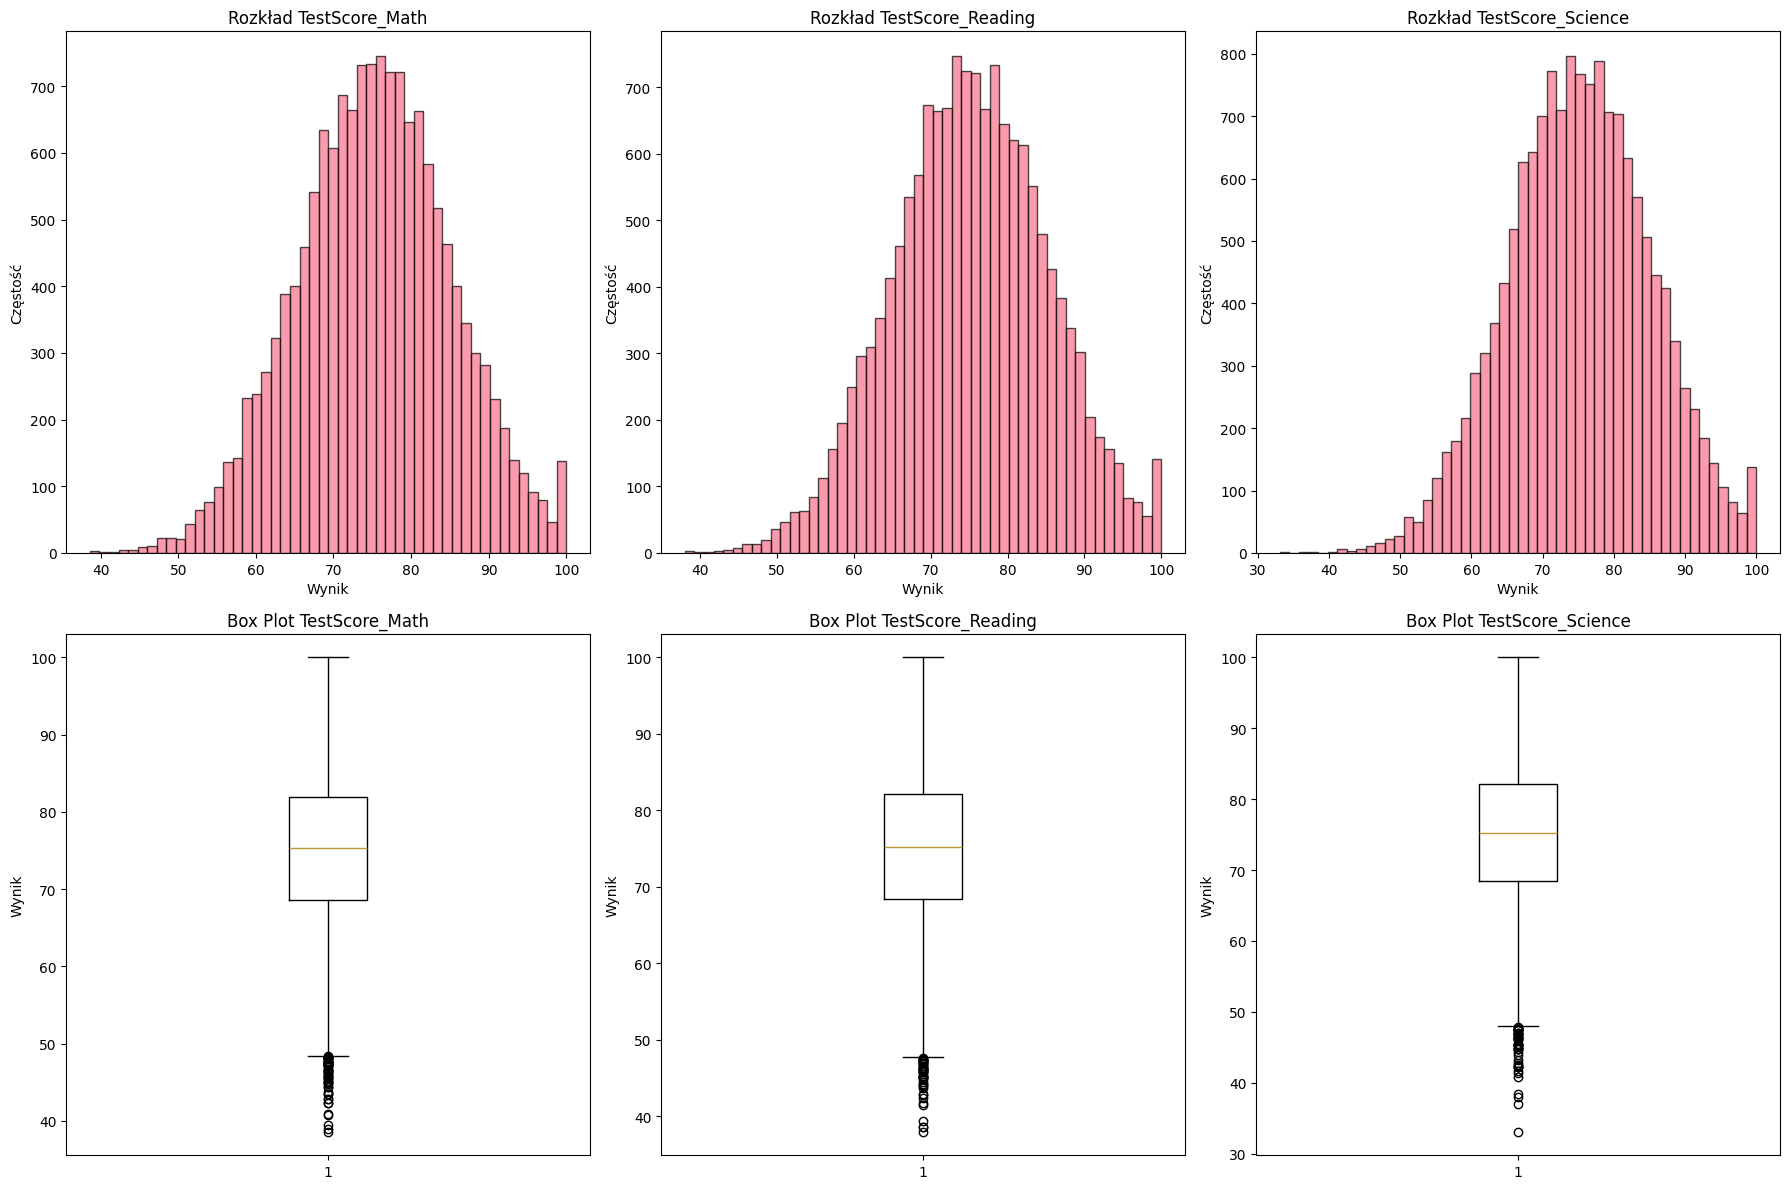

Korelacje między zmiennymi docelowymi:
                   TestScore_Math  TestScore_Reading  TestScore_Science
TestScore_Math           1.000000           0.704521           0.701896
TestScore_Reading        0.704521           1.000000           0.703283
TestScore_Science        0.701896           0.703283           1.000000


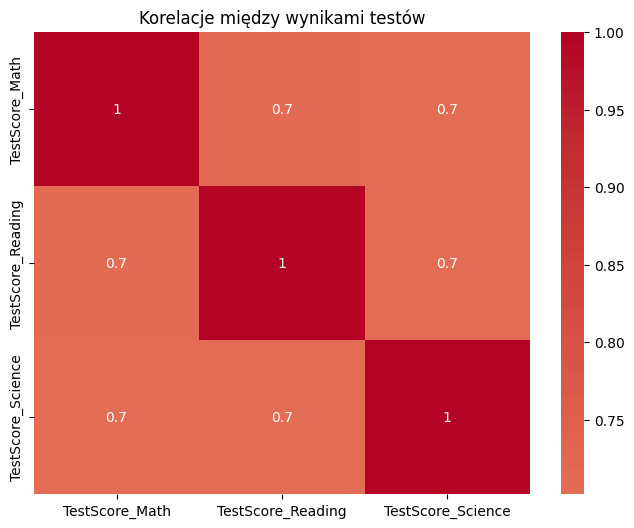

In [63]:
# Analiza zmiennych docelowych
target_vars = ['TestScore_Math', 'TestScore_Reading', 'TestScore_Science']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Histogramy
for i, target in enumerate(target_vars):
    axes[0, i].hist(train_df[target], bins=50, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'Rozkład {target}')
    axes[0, i].set_xlabel('Wynik')
    axes[0, i].set_ylabel('Częstość')

# Box plots
for i, target in enumerate(target_vars):
    axes[1, i].boxplot(train_df[target])
    axes[1, i].set_title(f'Box Plot {target}')
    axes[1, i].set_ylabel('Wynik')

plt.tight_layout()
plt.show()

# Korelacje między zmiennymi docelowymi
print("Korelacje między zmiennymi docelowymi:")
target_corr = train_df[target_vars].corr()
print(target_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Korelacje między wynikami testów')
plt.show()

### Analiza Cech Kategorycznych

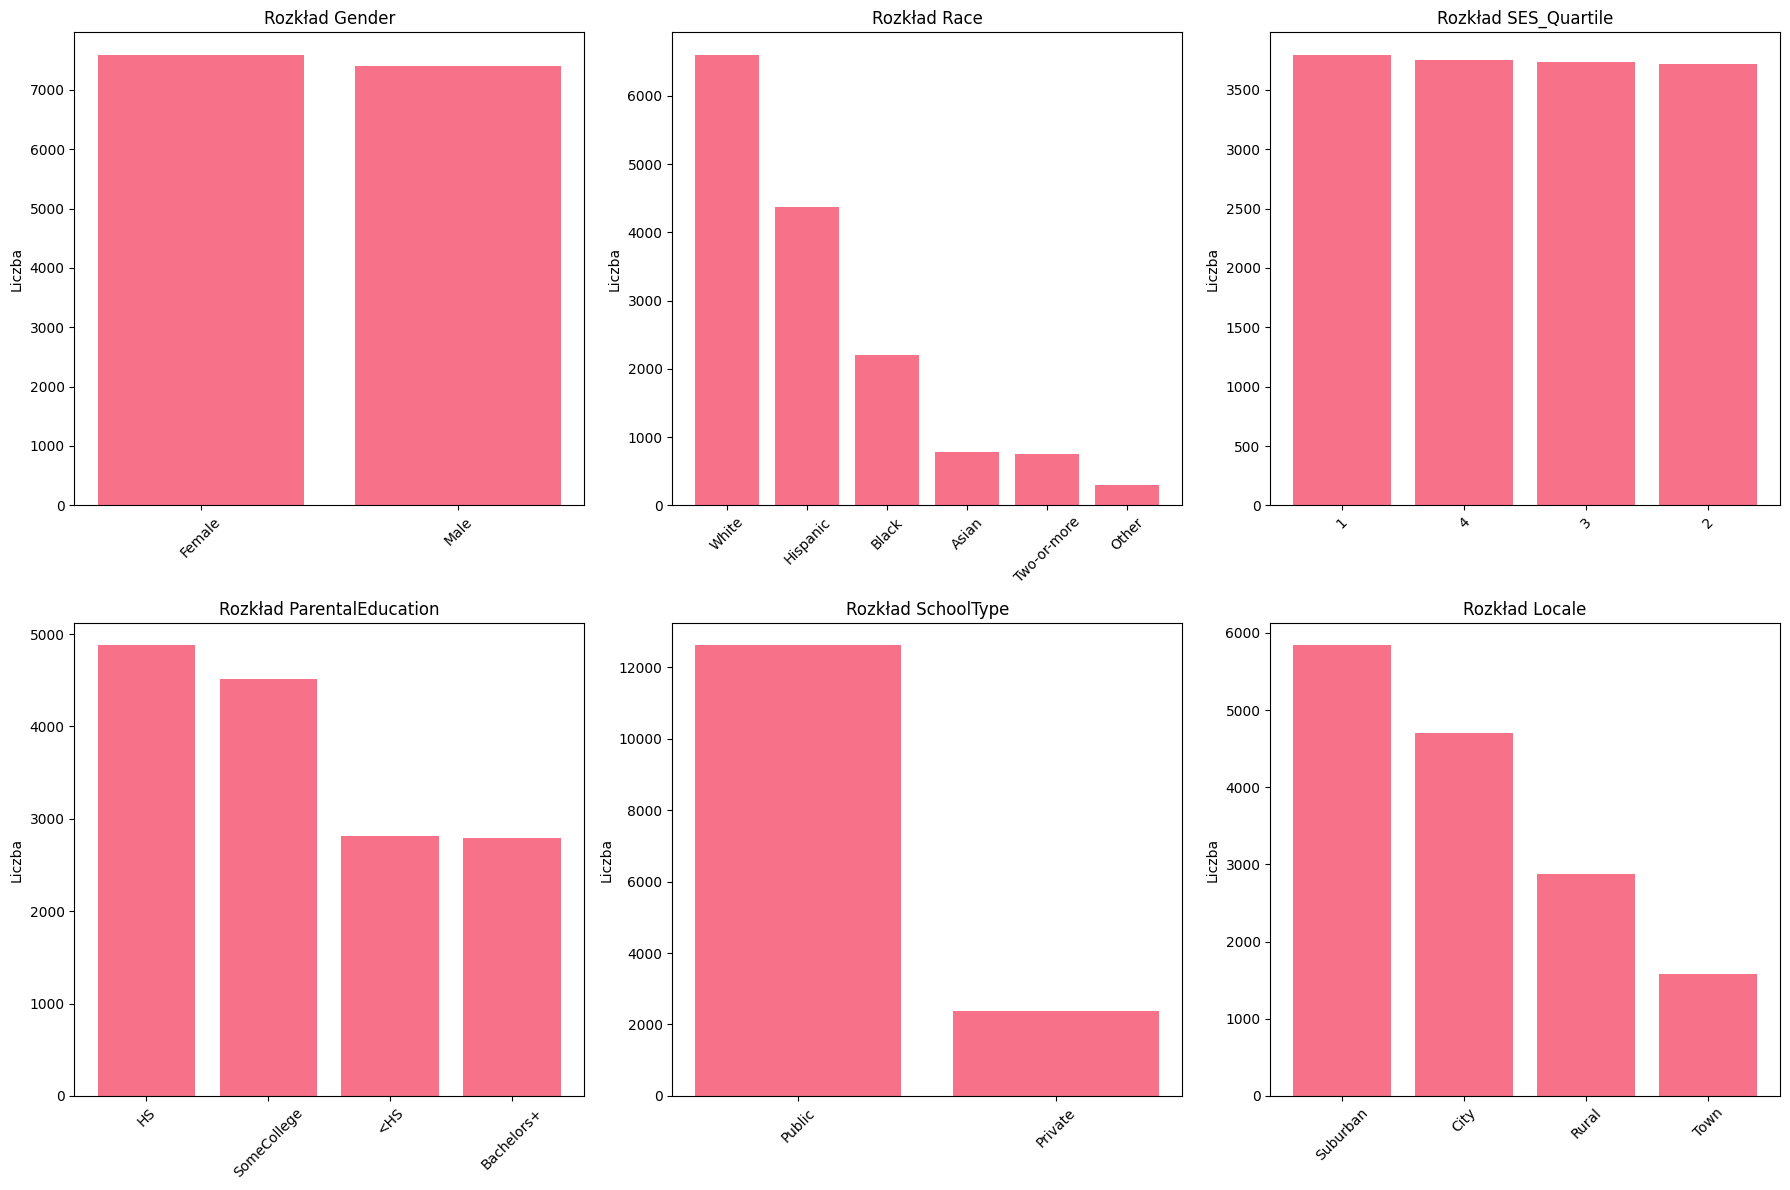

In [64]:
# Analiza rozkładu cech kategorycznych
categorical_features = ['Gender', 'Race', 'SES_Quartile', 'ParentalEducation',
                        'SchoolType', 'Locale']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    feature_counts = train_df[feature].value_counts()
    axes[i].bar(range(len(feature_counts)), feature_counts.values)
    axes[i].set_title(f'Rozkład {feature}')
    axes[i].set_xticks(range(len(feature_counts)))
    axes[i].set_xticklabels(feature_counts.index, rotation=45)
    axes[i].set_ylabel('Liczba')

plt.tight_layout()
plt.show()

### Analiza Wartości Odstających

Age: 0 wartości odstających (0.00%)
Grade: 0 wartości odstających (0.00%)
GPA: 50 wartości odstających (0.33%)
AttendanceRate: 54 wartości odstających (0.36%)
StudyHours: 97 wartości odstających (0.65%)
FreeTime: 0 wartości odstających (0.00%)
GoOut: 0 wartości odstających (0.00%)
TestScore_Math: 57 wartości odstających (0.38%)
TestScore_Reading: 45 wartości odstających (0.30%)
TestScore_Science: 49 wartości odstających (0.33%)


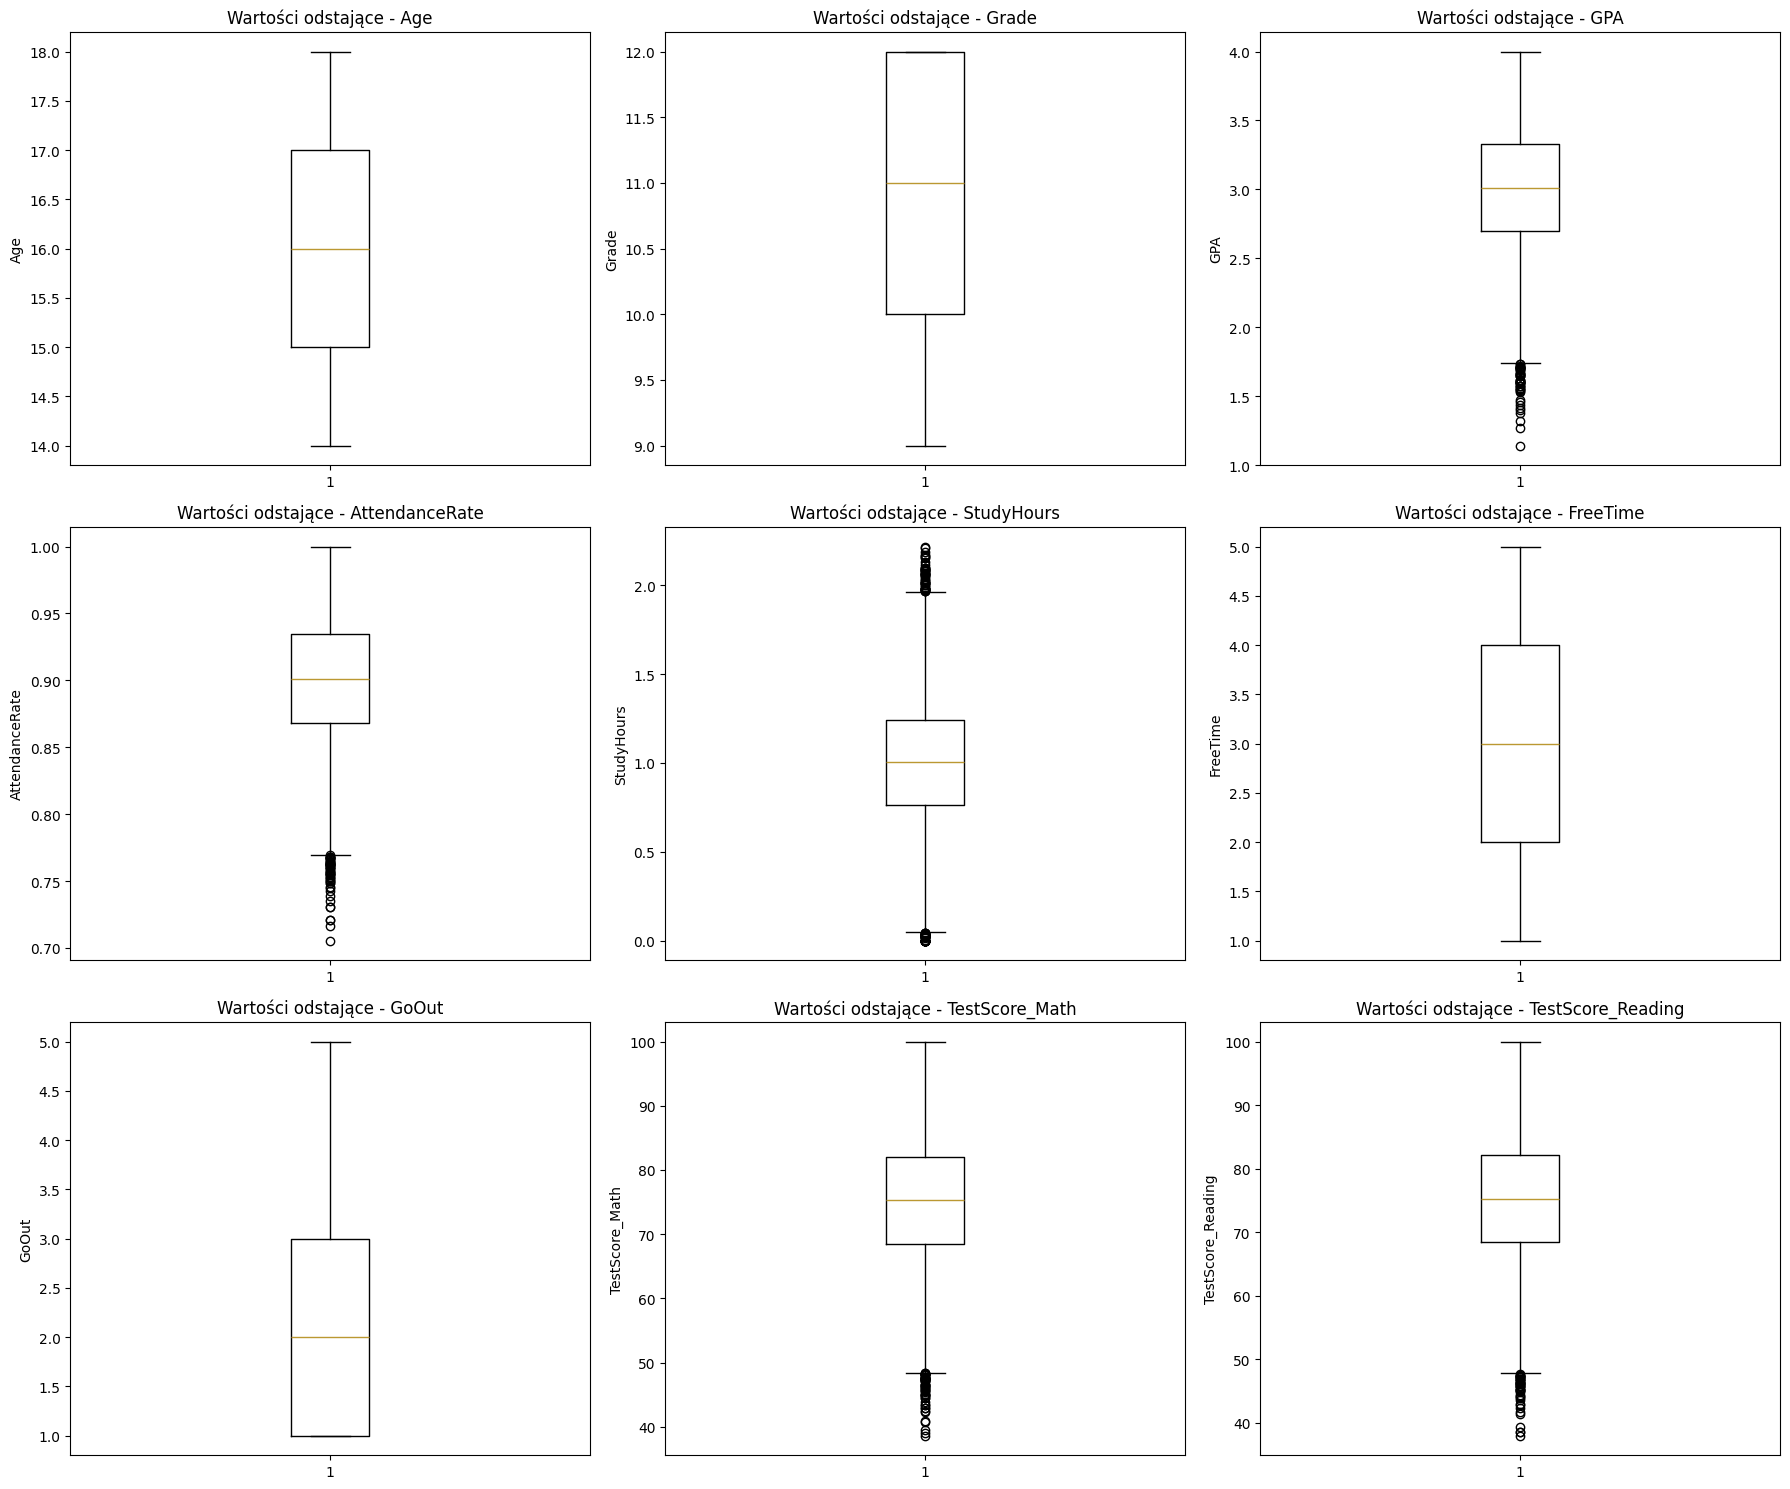

In [65]:
# Analiza wartości odstających dla zmiennych numerycznych
numeric_features = ['Age', 'Grade', 'GPA', 'AttendanceRate', 'StudyHours',
                    'FreeTime', 'GoOut'] + target_vars


# Metoda IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


outlier_summary = {}
for feature in numeric_features:
    outliers = detect_outliers_iqr(train_df, feature)
    outlier_summary[feature] = len(outliers)
    print(f"{feature}: {len(outliers)} wartości odstających ({len(outliers) / len(train_df) * 100:.2f}%)")

# Wizualizacja wartości odstających
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        axes[i].boxplot(train_df[feature])
        axes[i].set_title(f'Wartości odstające - {feature}')
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

### Analiza Korelacji

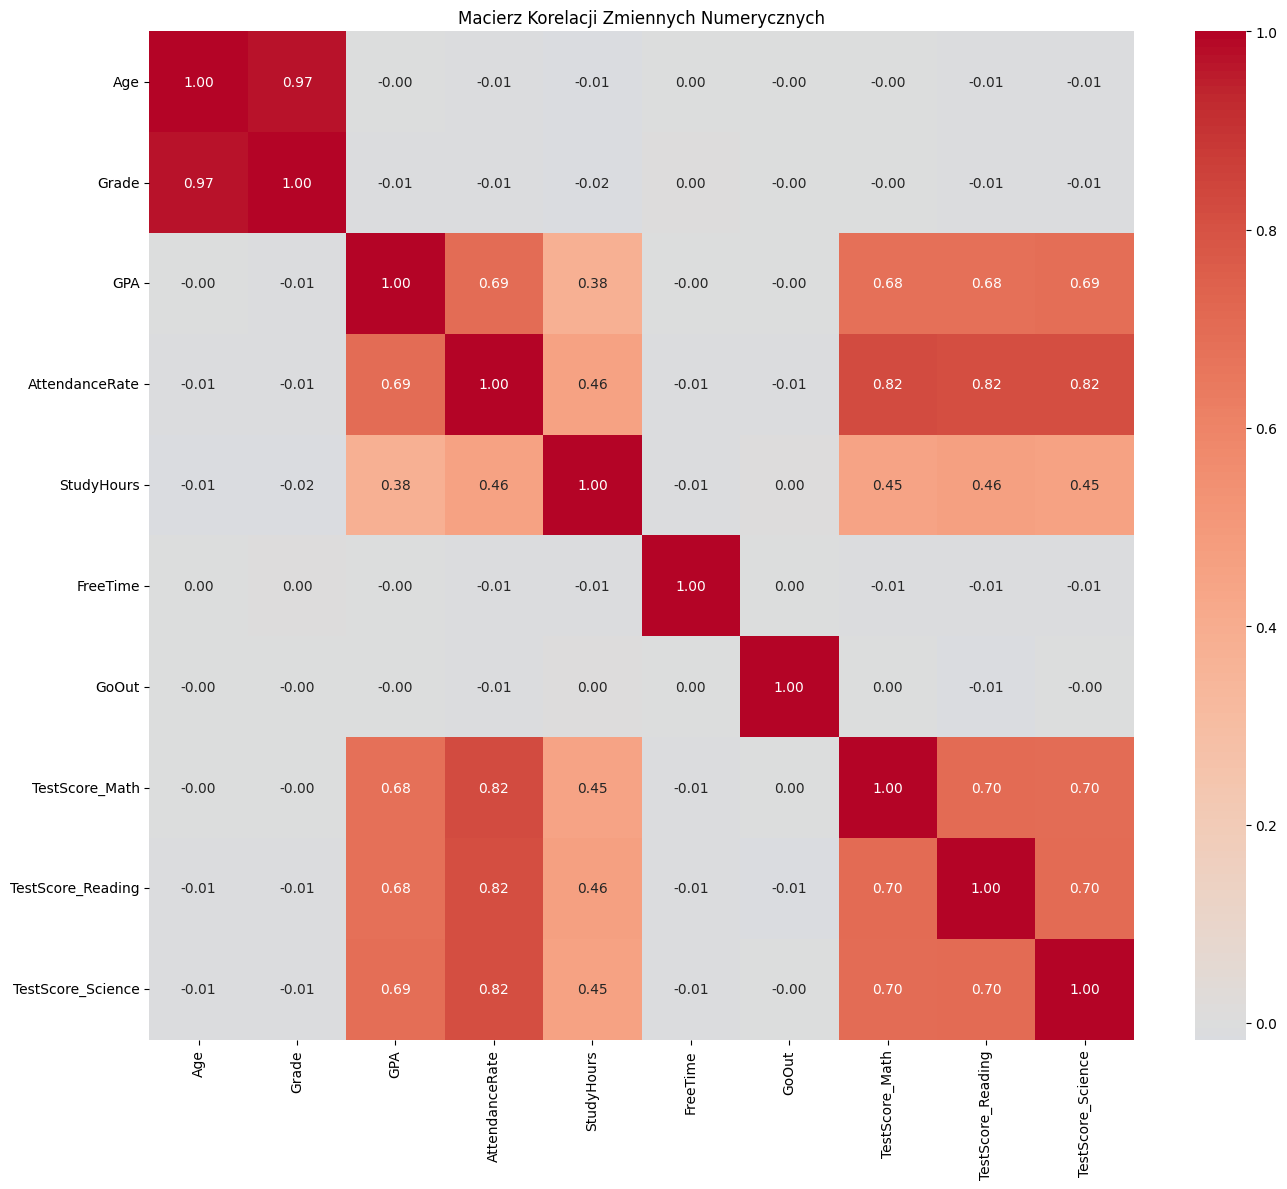

Najsilniejsze korelacje z wynikami testów:

TestScore_Math:
TestScore_Math       1.000000
AttendanceRate       0.817800
TestScore_Reading    0.704521
TestScore_Science    0.701896
GPA                  0.680679
StudyHours           0.448490
Name: TestScore_Math, dtype: float64

TestScore_Reading:
TestScore_Reading    1.000000
AttendanceRate       0.815054
TestScore_Math       0.704521
TestScore_Science    0.703283
GPA                  0.679095
StudyHours           0.462976
Name: TestScore_Reading, dtype: float64

TestScore_Science:
TestScore_Science    1.000000
AttendanceRate       0.815363
TestScore_Reading    0.703283
TestScore_Math       0.701896
GPA                  0.687150
StudyHours           0.452692
Name: TestScore_Science, dtype: float64


In [66]:
# Macierz korelacji dla wszystkich zmiennych numerycznych
plt.figure(figsize=(14, 12))
correlation_matrix = train_df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Macierz Korelacji Zmiennych Numerycznych')
plt.tight_layout()
plt.show()

# Najsilniejsze korelacje z zmiennymi docelowymi
print("Najsilniejsze korelacje z wynikami testów:")
for target in target_vars:
    print(f"\n{target}:")
    target_corr = correlation_matrix[target].abs().sort_values(ascending=False)
    print(target_corr.head(6))  # Top 5 + sama zmienna docelowa

### Kontrola Niezrównoważenia

In [67]:
# Analiza niezrównoważenia dla cech kategorycznych
print("Analiza równowagi w cechach kategorycznych:")
for feature in categorical_features:
    value_counts = train_df[feature].value_counts()
    proportions = value_counts / len(train_df) * 100
    print(f"\n{feature}:")
    for value, count, prop in zip(value_counts.index, value_counts.values, proportions.values):
        print(f"  {value}: {count} ({prop:.1f}%)")

    # Sprawdzenie czy jakaś kategoria ma mniej niż 5% obserwacji
    if proportions.min() < 5:
        print(f"!!!!!!! Niezrównoważenie detected: najmniejsza kategoria ma {proportions.min():.1f}%")

Analiza równowagi w cechach kategorycznych:

Gender:
  Female: 7590 (50.6%)
  Male: 7410 (49.4%)

Race:
  White: 6600 (44.0%)
  Hispanic: 4371 (29.1%)
  Black: 2199 (14.7%)
  Asian: 783 (5.2%)
  Two-or-more: 755 (5.0%)
  Other: 292 (1.9%)
!!!!!!! Niezrównoważenie detected: najmniejsza kategoria ma 1.9%

SES_Quartile:
  1: 3796 (25.3%)
  4: 3753 (25.0%)
  3: 3732 (24.9%)
  2: 3719 (24.8%)

ParentalEducation:
  HS: 4877 (32.5%)
  SomeCollege: 4516 (30.1%)
  <HS: 2811 (18.7%)
  Bachelors+: 2796 (18.6%)

SchoolType:
  Public: 12611 (84.1%)
  Private: 2389 (15.9%)

Locale:
  Suburban: 5838 (38.9%)
  City: 4702 (31.3%)
  Rural: 2882 (19.2%)
  Town: 1578 (10.5%)


## 3. Przetwarzanie i Inżynieria Cech

### Kodowanie Zmiennych Kategorycznych

In [68]:
# Przygotowanie danych do modelowania
def prepare_data(df):
    df_processed = df.copy()

    # One-hot encoding dla zmiennych kategorycznych
    categorical_features = ['Gender', 'Race', 'ParentalEducation', 'SchoolType', 'Locale']
    df_encoded = pd.get_dummies(df_processed, columns=categorical_features, prefix=categorical_features)

    return df_encoded


# Przygotowanie wszystkich zbiorów
train_processed = prepare_data(train_df)
val_processed = prepare_data(val_df)
test_processed = prepare_data(test_df)

print(f"Liczba cech po kodowaniu: {train_processed.shape[1]}")
print(f"Nowe cechy: {train_processed.shape[1] - train_df.shape[1]}")

Liczba cech po kodowaniu: 34
Nowe cechy: 13


### Inżynieria Cech

In [70]:
def feature_engineering(df):
    df_fe = df.copy()

    if all(col in df_fe.columns for col in target_vars):
        df_fe['AvgTestScore'] = df_fe[target_vars].mean(axis=1)

    df_fe['AcademicSuccess'] = df_fe['GPA'] * df_fe['AttendanceRate']
    df_fe['StudyFreeTimeRatio'] = df_fe['StudyHours'] / (df_fe['FreeTime'] + 1)  # +1 aby uniknąć dzielenia przez 0
    df_fe['SocialActivity'] = df_fe['GoOut'] + df_fe['FreeTime']
    df_fe['ExtraLoad'] = df_fe['PartTimeJob'] + df_fe['Extracurricular']
    df_fe['EnvironmentalSupport'] = df_fe['InternetAccess'] + df_fe['ParentSupport']
    df_fe['AgeQuartile'] = pd.qcut(df_fe['Age'], q=4, labels=[1, 2, 3, 4])

    return df_fe


# Zastosowanie inżynierii cech
train_processed = feature_engineering(train_processed)
val_processed = feature_engineering(val_processed)
test_processed = feature_engineering(test_processed)

print("Nowe cechy utworzone:")
new_features = ['AcademicSuccess', 'StudyFreeTimeRatio', 'SocialActivity',
                'ExtraLoad', 'EnvironmentalSupport', 'AgeQuartile']
for feature in new_features:
    if feature in train_processed.columns:
        print(f"- {feature}")

Nowe cechy utworzone:
- AcademicSuccess
- StudyFreeTimeRatio
- SocialActivity
- ExtraLoad
- EnvironmentalSupport
- AgeQuartile


### Selekcja Cech

In [71]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Przygotowanie danych do selekcji cech
X = train_processed.drop(target_vars + ['AvgTestScore'], axis=1, errors='ignore')
y = train_processed[target_vars]

# Uzupełnienie brakujących kolumn w val i test (jeśli występują różnice po one-hot encoding)
missing_cols_val = set(X.columns) - set(val_processed.columns)
missing_cols_test = set(X.columns) - set(test_processed.columns)

for col in missing_cols_val:
    val_processed[col] = 0
for col in missing_cols_test:
    test_processed[col] = 0

# Selekcja najlepszych cech za pomocą F-testu
selector = SelectKBest(score_func=f_regression, k=30)  # Wybierz 30 najlepszych cech
X_selected = selector.fit_transform(X, y.mean(axis=1))  # Używamy średniej z targetów do selekcji

# Nazwy wybranych cech
selected_features = X.columns[selector.get_support()].tolist()
print(f"Wybrane cechy ({len(selected_features)}):")
for i, feature in enumerate(selected_features):
    print(f"{i + 1:2d}. {feature}")

# Przygotowanie finalnych zbiorów danych
X_train = train_processed[selected_features]
X_val = val_processed[selected_features]
X_test = test_processed[selected_features]

y_train = train_processed[target_vars]
y_val = val_processed[target_vars]
y_test = test_processed[target_vars]

Wybrane cechy (30):
 1. Age
 2. Grade
 3. SES_Quartile
 4. GPA
 5. AttendanceRate
 6. StudyHours
 7. InternetAccess
 8. Extracurricular
 9. PartTimeJob
10. ParentSupport
11. FreeTime
12. GoOut
13. Gender_Female
14. Gender_Male
15. Race_Asian
16. Race_Black
17. Race_Hispanic
18. Race_White
19. SchoolType_Private
20. SchoolType_Public
21. Locale_City
22. Locale_Rural
23. Locale_Suburban
24. Locale_Town
25. AcademicSuccess
26. StudyFreeTimeRatio
27. SocialActivity
28. ExtraLoad
29. EnvironmentalSupport
30. AgeQuartile


### Standaryzacja

In [72]:
# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Kształty finalnych zbiorów:")
print(f"X_train: {X_train_scaled.shape}")
print(f"X_val: {X_val_scaled.shape}")
print(f"X_test: {X_test_scaled.shape}")
print(f"y_train: {y_train.shape}")

Kształty finalnych zbiorów:
X_train: (15000, 30)
X_val: (1875, 30)
X_test: (1875, 30)
y_train: (15000, 3)


## 4. Budowanie Modeli

### Wybór, konfiguracja i trenowanie Modeli

In [75]:
# Definicja modeli do testowania
models = {
    'Linear_Regression': MultiOutputRegressor(LinearRegression()),
    'Ridge_Regression': MultiOutputRegressor(Ridge(alpha=1.0, random_state=42)),
    'Random_Forest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    'Gradient_Boosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'MLP_Neural_Network': MultiOutputRegressor(
        MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

print("Modele do trenowania:")
for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i}. {name}")

# Funkcja do oceny modeli
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    print(f"\n{'=' * 50}")
    print(f"Trenowanie modelu: {model_name}")
    print(f"{'=' * 50}")

    model.fit(X_train, y_train)

    # Predykcje
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metryki dla każdego targetu
    train_scores = {}
    val_scores = {}

    for i, target in enumerate(target_vars):
        # MSE
        train_mse = mean_squared_error(y_train.iloc[:, i], y_train_pred[:, i])
        val_mse = mean_squared_error(y_val.iloc[:, i], y_val_pred[:, i])

        # R²
        train_r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
        val_r2 = r2_score(y_val.iloc[:, i], y_val_pred[:, i])

        # MAE
        train_mae = mean_absolute_error(y_train.iloc[:, i], y_train_pred[:, i])
        val_mae = mean_absolute_error(y_val.iloc[:, i], y_val_pred[:, i])

        train_scores[target] = {'MSE': train_mse, 'R2': train_r2, 'MAE': train_mae}
        val_scores[target] = {'MSE': val_mse, 'R2': val_r2, 'MAE': val_mae}

        print(f"\n{target}:")
        print(f"  Train - MSE: {train_mse:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
        print(f"  Val   - MSE: {val_mse:.4f}, R²: {val_r2:.4f}, MAE: {val_mae:.4f}")

    # Średnie metryki
    avg_train_r2 = np.mean([scores['R2'] for scores in train_scores.values()])
    avg_val_r2 = np.mean([scores['R2'] for scores in val_scores.values()])
    avg_train_mse = np.mean([scores['MSE'] for scores in train_scores.values()])
    avg_val_mse = np.mean([scores['MSE'] for scores in val_scores.values()])

    print(f"\nŚrednie wyniki:")
    print(f"  Train - R²: {avg_train_r2:.4f}, MSE: {avg_train_mse:.4f}")
    print(f"  Val   - R²: {avg_val_r2:.4f}, MSE: {avg_val_mse:.4f}")

    # Kontrola przeuczenia
    overfitting_r2 = avg_train_r2 - avg_val_r2
    overfitting_mse = avg_val_mse - avg_train_mse

    print(f"\nKontrola przeuczenia:")
    print(f"  Różnica R² (train-val): {overfitting_r2:.4f}")
    print(f"  Różnica MSE (val-train): {overfitting_mse:.4f}")

    if overfitting_r2 > 0.1:
        print("!!!!!!! UWAGA: Możliwe przeuczenie (różnica R² > 0.1)")
    elif overfitting_r2 > 0.05:
        print("!!!! Lekkie przeuczenie (różnica R² > 0.05)")
    else:
        print("[OK] Brak oznk przeuczenia")

    return {
        'model': model,
        'train_scores': train_scores,
        'val_scores': val_scores,
        'avg_train_r2': avg_train_r2,
        'avg_val_r2': avg_val_r2,
        'avg_train_mse': avg_train_mse,
        'avg_val_mse': avg_val_mse,
        'overfitting_r2': overfitting_r2,
        'predictions': {'train': y_train_pred, 'val': y_val_pred}
    }


# Trenowanie wszystkich modeli
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_val_scaled, y_train, y_val, name)

Modele do trenowania:
1. Linear_Regression
2. Ridge_Regression
3. Random_Forest
4. Gradient_Boosting
5. MLP_Neural_Network

Trenowanie modelu: Linear_Regression

TestScore_Math:
  Train - MSE: 29.8448, R²: 0.6984, MAE: 4.3652
  Val   - MSE: 28.6565, R²: 0.7225, MAE: 4.2931

TestScore_Reading:
  Train - MSE: 30.5181, R²: 0.6969, MAE: 4.4248
  Val   - MSE: 31.6730, R²: 0.6893, MAE: 4.5188

TestScore_Science:
  Train - MSE: 30.2882, R²: 0.6988, MAE: 4.4140
  Val   - MSE: 30.6645, R²: 0.6990, MAE: 4.4168

Średnie wyniki:
  Train - R²: 0.6980, MSE: 30.2171
  Val   - R²: 0.7036, MSE: 30.3313

Kontrola przeuczenia:
  Różnica R² (train-val): -0.0056
  Różnica MSE (val-train): 0.1143
[OK] Brak oznk przeuczenia

Trenowanie modelu: Ridge_Regression

TestScore_Math:
  Train - MSE: 29.8448, R²: 0.6984, MAE: 4.3652
  Val   - MSE: 28.6564, R²: 0.7225, MAE: 4.2931

TestScore_Reading:
  Train - MSE: 30.5181, R²: 0.6969, MAE: 4.4248
  Val   - MSE: 31.6726, R²: 0.6893, MAE: 4.5188

TestScore_Science:
  T

### Wizualizacja Wyników Modeli

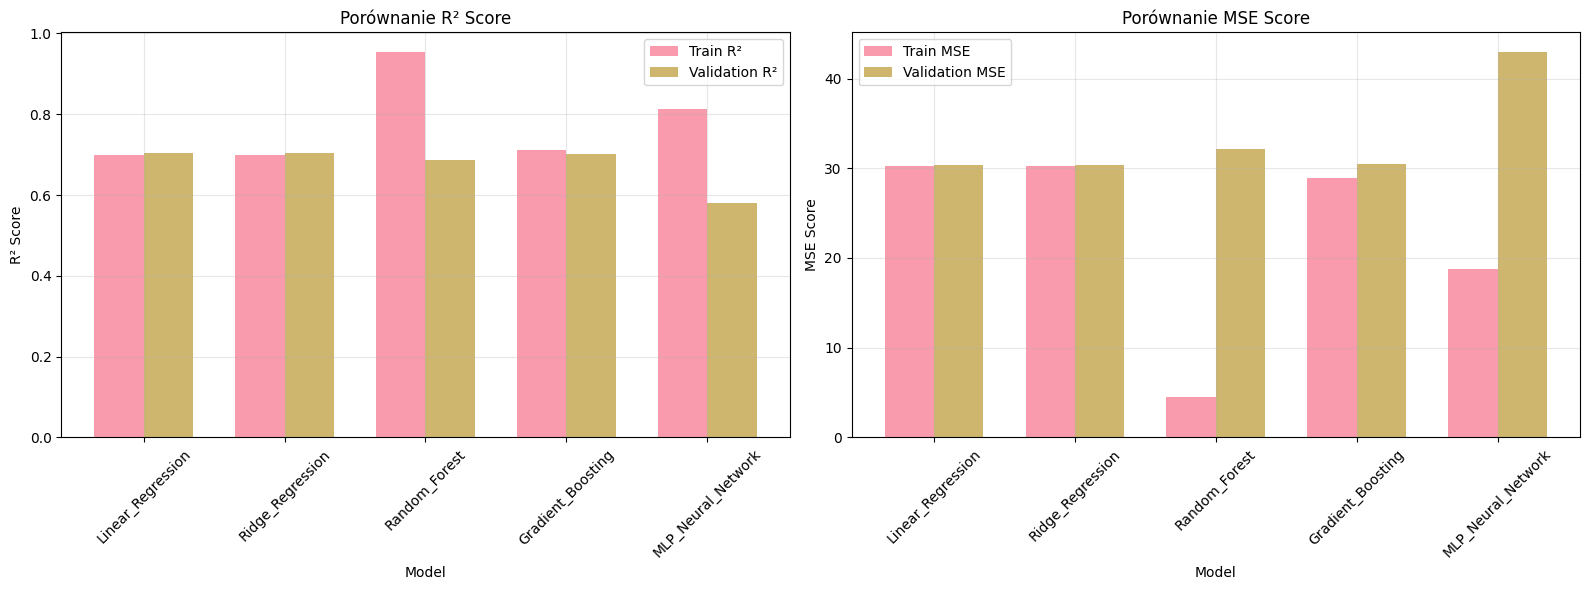

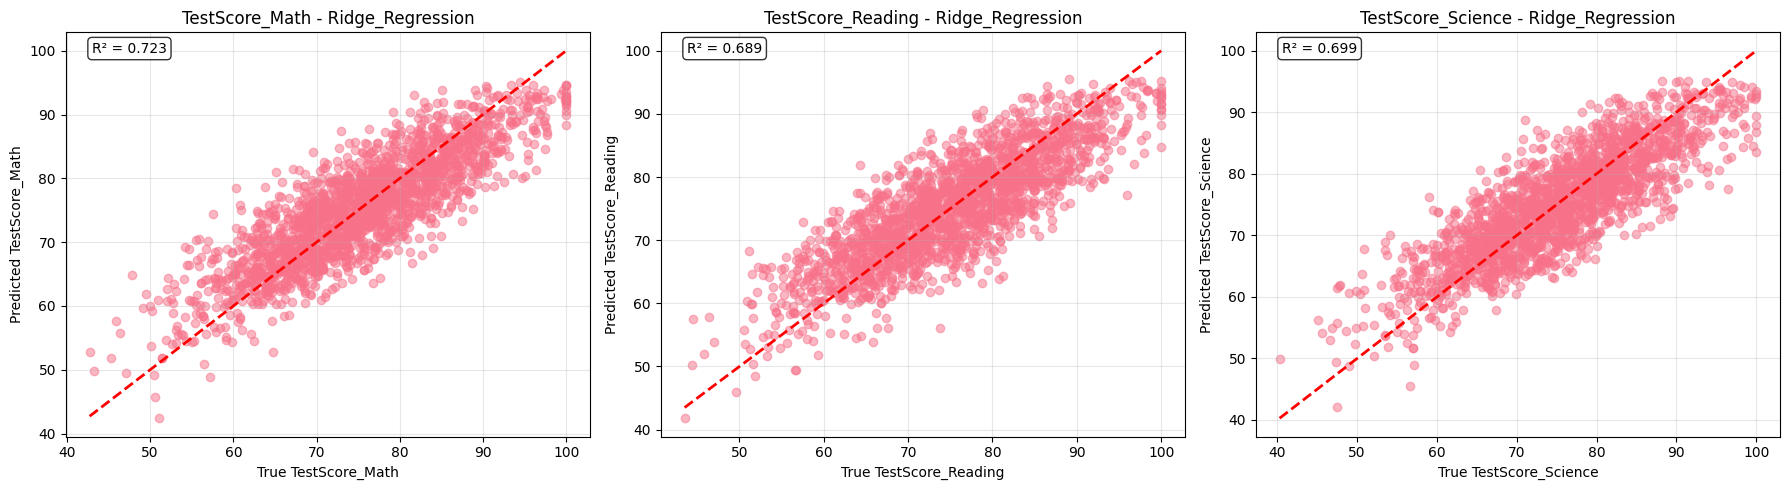


Najlepszy model: Ridge_Regression
Średnie R² na walidacji: 0.7036


In [76]:
# Porównanie wyników wszystkich modeli
model_names = list(results.keys())
train_r2_scores = [results[name]['avg_train_r2'] for name in model_names]
val_r2_scores = [results[name]['avg_val_r2'] for name in model_names]
train_mse_scores = [results[name]['avg_train_mse'] for name in model_names]
val_mse_scores = [results[name]['avg_val_mse'] for name in model_names]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² scores
x_pos = np.arange(len(model_names))
width = 0.35

axes[0].bar(x_pos - width / 2, train_r2_scores, width, label='Train R²', alpha=0.7)
axes[0].bar(x_pos + width / 2, val_r2_scores, width, label='Validation R²', alpha=0.7)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Porównanie R² Score')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MSE scores
axes[1].bar(x_pos - width / 2, train_mse_scores, width, label='Train MSE', alpha=0.7)
axes[1].bar(x_pos + width / 2, val_mse_scores, width, label='Validation MSE', alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MSE Score')
axes[1].set_title('Porównanie MSE Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Wykres rozrzutu - prawdziwe vs przewidziane wartości dla najlepszego modelu
best_model_name = max(results.keys(), key=lambda x: results[x]['avg_val_r2'])
best_result = results[best_model_name]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, target in enumerate(target_vars):
    y_true = y_val.iloc[:, i].values
    y_pred = best_result['predictions']['val'][:, i]

    axes[i].scatter(y_true, y_pred, alpha=0.5)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[i].set_xlabel(f'True {target}')
    axes[i].set_ylabel(f'Predicted {target}')
    axes[i].set_title(f'{target} - {best_model_name}')
    axes[i].grid(True, alpha=0.3)

    # R² na wykresie
    r2 = results[best_model_name]['val_scores'][target]['R2']
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\nNajlepszy model: {best_model_name}")
print(f"Średnie R² na walidacji: {results[best_model_name]['avg_val_r2']:.4f}")

## 5. Optymalizacja Hiperparametrów

### Grid Search dla Najlepszych Modeli

In [80]:
def optimize_hyperparameters(model, param_grid, X_train, y_train, model_name):
    print(f"\nOptymalizacja hiperparametrów dla {model_name}...")
    
    base_estimator = model.estimator
    
    base_param_grid = {}
    for key, value in param_grid.items():
        if key.startswith('estimator__'):
            new_key = key.replace('estimator__', '')
            base_param_grid[new_key] = value
        else:
            base_param_grid[key] = value
    
    y_mean = y_train.mean(axis=1)
    
    grid_search = GridSearchCV(
        base_estimator, base_param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_mean)
    
    print(f"Najlepsze parametry: {grid_search.best_params_}")
    print(f"Najlepszy wynik CV: {grid_search.best_score_:.4f}")
    
    best_base_estimator = grid_search.best_estimator_
    best_model = MultiOutputRegressor(best_base_estimator)
    
    return best_model, grid_search.best_params_, grid_search.best_score_


param_grids_corrected = {
    'Random_Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Ridge_Regression': {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Gradient_Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'MLP_Neural_Network': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (200, 100)],
        'alpha': [0.0001, 0.001, 0.01]
    }
}

optimized_results = {}
for model_name in top_2_models:
    if model_name in param_grids_corrected:
        original_model = models[model_name]
        param_grid = param_grids_corrected[model_name]
        
        best_model, best_params, best_cv_score = optimize_hyperparameters(
            original_model, param_grid, X_train_scaled, y_train, model_name
        )
        
        optimized_result = evaluate_model(
            best_model, X_train_scaled, X_val_scaled, y_train, y_val,
            f"{model_name}_Optimized"
        )
        
        optimized_results[f"{model_name}_Optimized"] = {
            **optimized_result,
            'best_params': best_params,
            'cv_score': best_cv_score
        }


Optymalizacja hiperparametrów dla Ridge_Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Najlepsze parametry: {'alpha': 10.0}
Najlepszy wynik CV: 0.8690

Trenowanie modelu: Ridge_Regression_Optimized

TestScore_Math:
  Train - MSE: 29.8449, R²: 0.6984, MAE: 4.3652
  Val   - MSE: 28.6560, R²: 0.7225, MAE: 4.2931

TestScore_Reading:
  Train - MSE: 30.5182, R²: 0.6969, MAE: 4.4248
  Val   - MSE: 31.6693, R²: 0.6894, MAE: 4.5186

TestScore_Science:
  Train - MSE: 30.2883, R²: 0.6988, MAE: 4.4140
  Val   - MSE: 30.6644, R²: 0.6990, MAE: 4.4167

Średnie wyniki:
  Train - R²: 0.6980, MSE: 30.2171
  Val   - R²: 0.7036, MSE: 30.3299

Kontrola przeuczenia:
  Różnica R² (train-val): -0.0056
  Różnica MSE (val-train): 0.1128
[OK] Brak oznk przeuczenia


## 6. Finalna Ewaluacja na Zbiorze Testowym

In [81]:
# Wybór najlepszego modelu (oryginalny vs optymalizowany)
all_results = {**results, **optimized_results}
final_model_name = max(all_results.keys(), key=lambda x: all_results[x]['avg_val_r2'])
final_model = all_results[final_model_name]['model']

print(f"Finalny model: {final_model_name}")
print(f"R² na walidacji: {all_results[final_model_name]['avg_val_r2']:.4f}")

# Ewaluacja na zbiorze testowym
print(f"\n{'=' * 60}")
print("FINALNA EWALUACJA NA ZBIORZE TESTOWYM")
print(f"{'=' * 60}")

# Predykcje na zbiorze testowym
y_test_pred = final_model.predict(X_test_scaled)

# Metryki finalne
final_test_scores = {}
print(f"\nWyniki dla modelu: {final_model_name}")
print("-" * 40)

for i, target in enumerate(target_vars):
    test_mse = mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i])
    test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    test_mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
    test_rmse = np.sqrt(test_mse)

    final_test_scores[target] = {
        'MSE': test_mse, 'RMSE': test_rmse, 'MAE': test_mae, 'R2': test_r2
    }

    print(f"{target}:")
    print(f"  R² = {test_r2:.4f}")
    print(f"  MSE = {test_mse:.4f}")
    print(f"  RMSE = {test_rmse:.4f}")
    print(f"  MAE = {test_mae:.4f}")

# Średnie wyniki
avg_test_r2 = np.mean([scores['R2'] for scores in final_test_scores.values()])
avg_test_mse = np.mean([scores['MSE'] for scores in final_test_scores.values()])
avg_test_rmse = np.mean([scores['RMSE'] for scores in final_test_scores.values()])
avg_test_mae = np.mean([scores['MAE'] for scores in final_test_scores.values()])

print(f"\nŚREDNIE WYNIKI FINALNE:")
print(f"R² = {avg_test_r2:.4f}")
print(f"MSE = {avg_test_mse:.4f}")
print(f"RMSE = {avg_test_rmse:.4f}")
print(f"MAE = {avg_test_mae:.4f}")

Finalny model: Ridge_Regression_Optimized
R² na walidacji: 0.7036

FINALNA EWALUACJA NA ZBIORZE TESTOWYM

Wyniki dla modelu: Ridge_Regression_Optimized
----------------------------------------
TestScore_Math:
  R² = 0.7092
  MSE = 28.1767
  RMSE = 5.3082
  MAE = 4.2307
TestScore_Reading:
  R² = 0.6837
  MSE = 31.4338
  RMSE = 5.6066
  MAE = 4.4766
TestScore_Science:
  R² = 0.6771
  MSE = 29.6511
  RMSE = 5.4453
  MAE = 4.3170

ŚREDNIE WYNIKI FINALNE:
R² = 0.6900
MSE = 29.7539
RMSE = 5.4533
MAE = 4.3415


### Wizualizacja wyników finalnych 

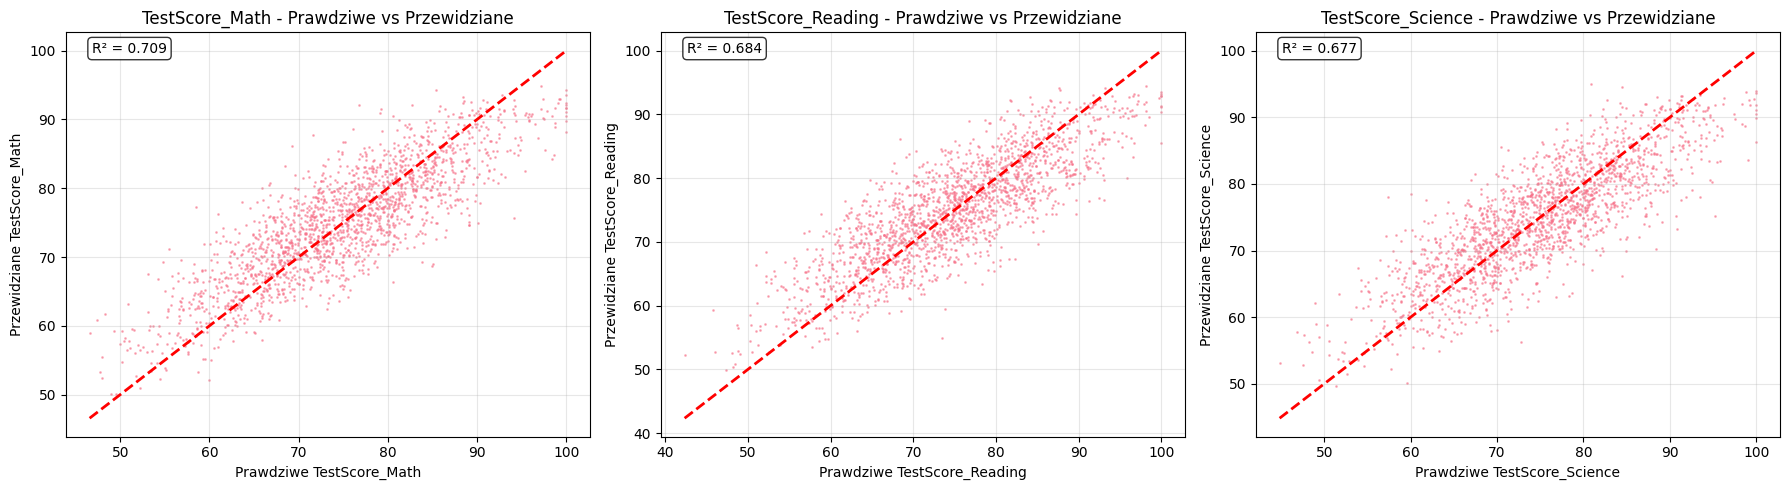

In [82]:
# Wykres porównawczy prawdziwe vs przewidziane wartości dla zboru testowego
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, target in enumerate(target_vars):
    y_true = y_test.iloc[:, i].values
    y_pred = y_test_pred[:, i]

    axes[i].scatter(y_true, y_pred, alpha=0.5, s=1)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[i].set_xlabel(f'Prawdziwe {target}')
    axes[i].set_ylabel(f'Przewidziane {target}')
    axes[i].set_title(f'{target} - Prawdziwe vs Przewidziane')
    axes[i].grid(True, alpha=0.3)

    # Dodanie R² na wykres
    r2 = final_test_scores[target]['R2']
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Krzywe ROC (dla klasyfikacji binarnej z podziałem wyników)

Analiza ROC - przekształcenie na problem klasyfikacji:
Wysokie wyniki = powyżej mediany, Niskie wyniki = poniżej mediany


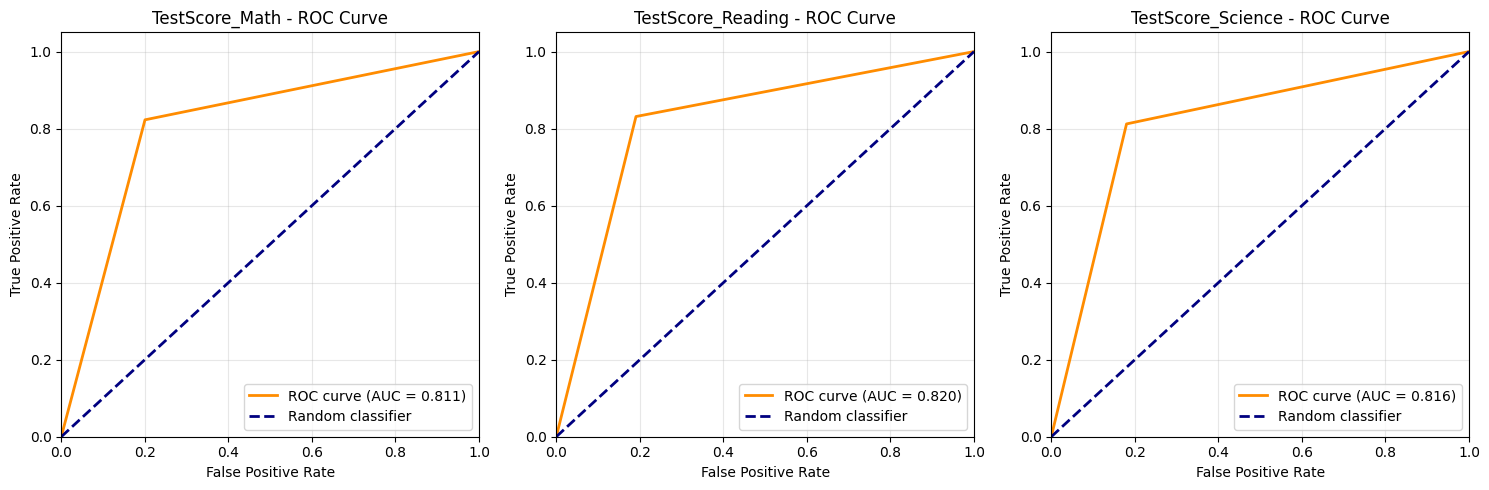

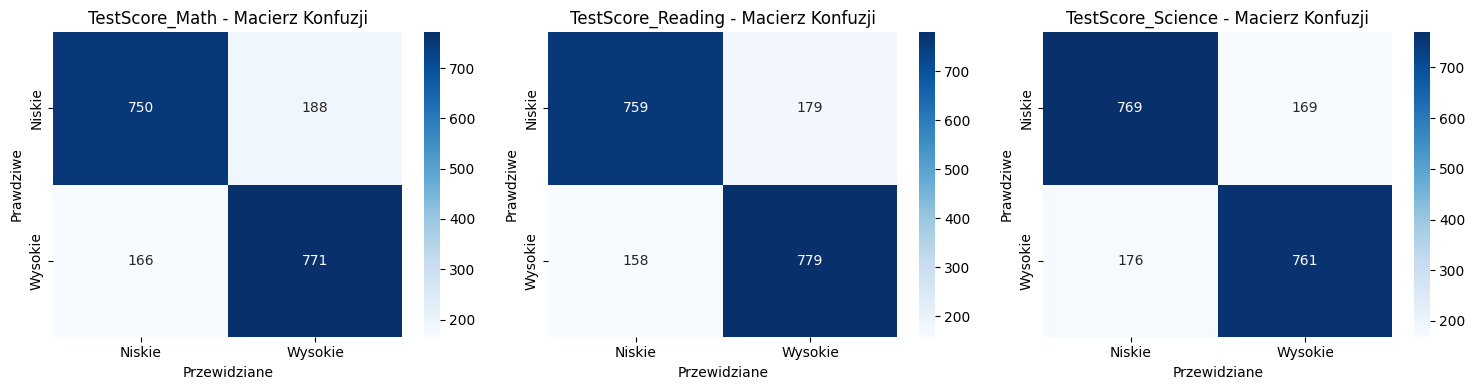

In [83]:
# Przekształcenie problemu regresji na klasyfikację binarną dla analizy ROC
# Definiujemy "wysokie wyniki" jako powyżej mediany
from sklearn.metrics import roc_curve, auc, confusion_matrix

print("Analiza ROC - przekształcenie na problem klasyfikacji:")
print("Wysokie wyniki = powyżej mediany, Niskie wyniki = poniżej mediany")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, target in enumerate(target_vars):
    # Przekształcenie na problem binarny
    median_score = np.median(y_test.iloc[:, i])
    y_true_binary = (y_test.iloc[:, i] > median_score).astype(int)
    y_pred_proba = (y_test_pred[:, i] > median_score).astype(float)

    # Krzywa ROC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random classifier')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{target} - ROC Curve')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Macierze konfuzji dla klasyfikacji binarnej
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, target in enumerate(target_vars):
    median_score = np.median(y_test.iloc[:, i])
    y_true_binary = (y_test.iloc[:, i] > median_score).astype(int)
    y_pred_binary = (y_test_pred[:, i] > median_score).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Przewidziane')
    axes[i].set_ylabel('Prawdziwe')
    axes[i].set_title(f'{target} - Macierz Konfuzji')
    axes[i].set_xticklabels(['Niskie', 'Wysokie'])
    axes[i].set_yticklabels(['Niskie', 'Wysokie'])

plt.tight_layout()
plt.show()

## 7. Porównanie Wszystkich Modeli


KOMPLETNE PORÓWNANIE WSZYSTKICH MODELI

Ranking modeli według R² na walidacji:
----------------------------------------------------------------------
 1. Ridge_Regression_Optimized | Val R²: 0.7036 | Overfitting: -0.0056
 2. Ridge_Regression          | Val R²: 0.7036 | Overfitting: -0.0056
 3. Linear_Regression         | Val R²: 0.7036 | Overfitting: -0.0056
 4. Gradient_Boosting         | Val R²: 0.7018 | Overfitting: +0.0095
 5. Random_Forest             | Val R²: 0.6855 | Overfitting: +0.2695
 6. MLP_Neural_Network        | Val R²: 0.5800 | Overfitting: +0.2328


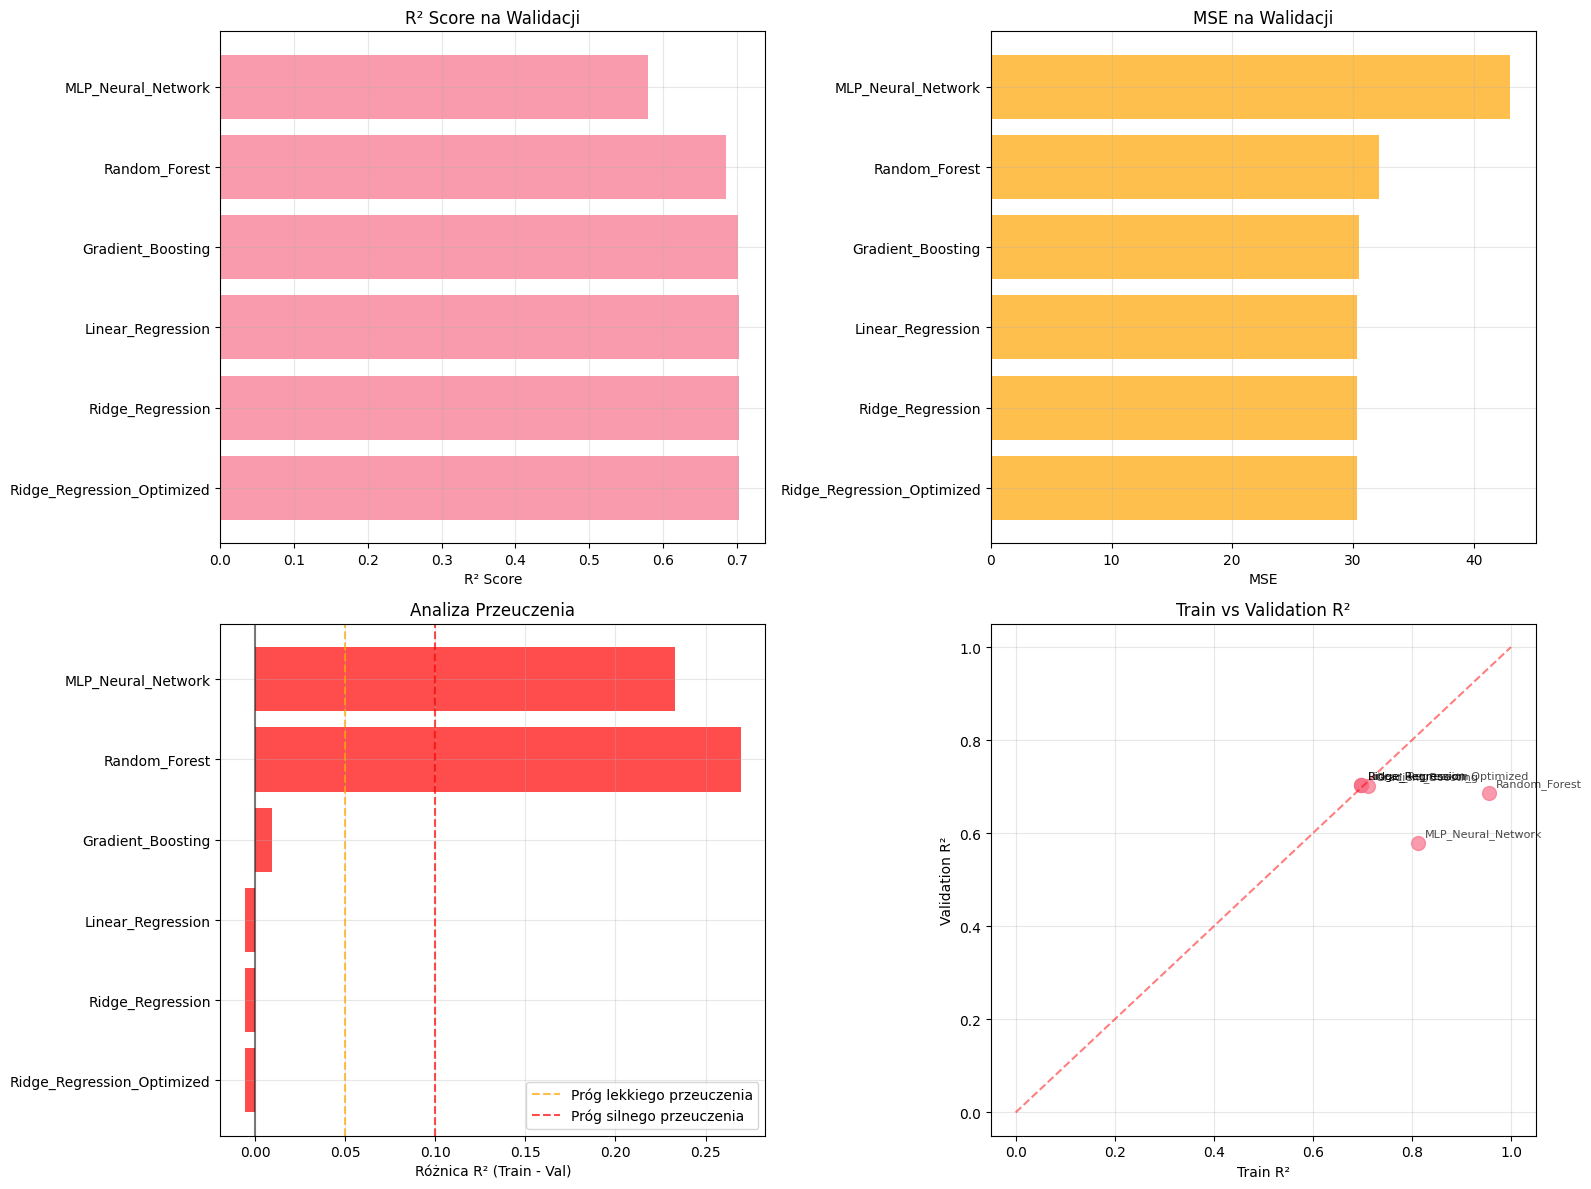

In [84]:
# Kompletne porównanie wszystkich modeli
print("\n" + "=" * 80)
print("KOMPLETNE PORÓWNANIE WSZYSTKICH MODELI")
print("=" * 80)

comparison_data = []
for model_name, result in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Train_R2': result['avg_train_r2'],
        'Val_R2': result['avg_val_r2'],
        'Train_MSE': result['avg_train_mse'],
        'Val_MSE': result['avg_val_mse'],
        'Overfitting_R2': result['overfitting_r2']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val_R2', ascending=False)

print("\nRanking modeli według R² na walidacji:")
print("-" * 70)
for i, row in comparison_df.iterrows():
    print(f"{comparison_df.index.get_loc(i) + 1:2d}. {row['Model']:25} | "
          f"Val R²: {row['Val_R2']:.4f} | "
          f"Overfitting: {row['Overfitting_R2']:+.4f}")

# Wykres porównawczy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score
axes[0, 0].barh(comparison_df['Model'], comparison_df['Val_R2'], alpha=0.7)
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('R² Score na Walidacji')
axes[0, 0].grid(True, alpha=0.3)

# MSE Score
axes[0, 1].barh(comparison_df['Model'], comparison_df['Val_MSE'], alpha=0.7, color='orange')
axes[0, 1].set_xlabel('MSE')
axes[0, 1].set_title('MSE na Walidacji')
axes[0, 1].grid(True, alpha=0.3)

# Overfitting Analysis
axes[1, 0].barh(comparison_df['Model'], comparison_df['Overfitting_R2'], alpha=0.7, color='red')
axes[1, 0].axvline(x=0, color='black', linestyle='-', alpha=0.5)
axes[1, 0].axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Próg lekkiego przeuczenia')
axes[1, 0].axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Próg silnego przeuczenia')
axes[1, 0].set_xlabel('Różnica R² (Train - Val)')
axes[1, 0].set_title('Analiza Przeuczenia')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Train vs Val R²
axes[1, 1].scatter(comparison_df['Train_R2'], comparison_df['Val_R2'], s=100, alpha=0.7)
axes[1, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5)
axes[1, 1].set_xlabel('Train R²')
axes[1, 1].set_ylabel('Validation R²')
axes[1, 1].set_title('Train vs Validation R²')
axes[1, 1].grid(True, alpha=0.3)

# Dodanie etykiet do punktów
for i, row in comparison_df.iterrows():
    axes[1, 1].annotate(row['Model'],
                        (row['Train_R2'], row['Val_R2']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

## 8. Analiza Ważności Cech


ANALIZA WSPÓŁCZYNNIKÓW MODELU LINIOWEGO

Top 15 cech z największymi współczynnikami (wartość bezwzględna):
----------------------------------------------------------------------
 1. AttendanceRate                 | +5.7820
 2. AcademicSuccess                | +1.8499
 3. StudyHours                     | +0.9148
 4. GPA                            | +0.6693
 5. Age                            | +0.1630
 6. Grade                          | -0.0898
 7. StudyFreeTimeRatio             | -0.0788
 8. AgeQuartile                    | -0.0747
 9. FreeTime                       | -0.0684
10. Race_White                     | +0.0667
11. Race_Hispanic                  | +0.0570
12. SocialActivity                 | -0.0413
13. SES_Quartile                   | -0.0266
14. Race_Asian                     | +0.0240
15. Locale_Town                    | +0.0234


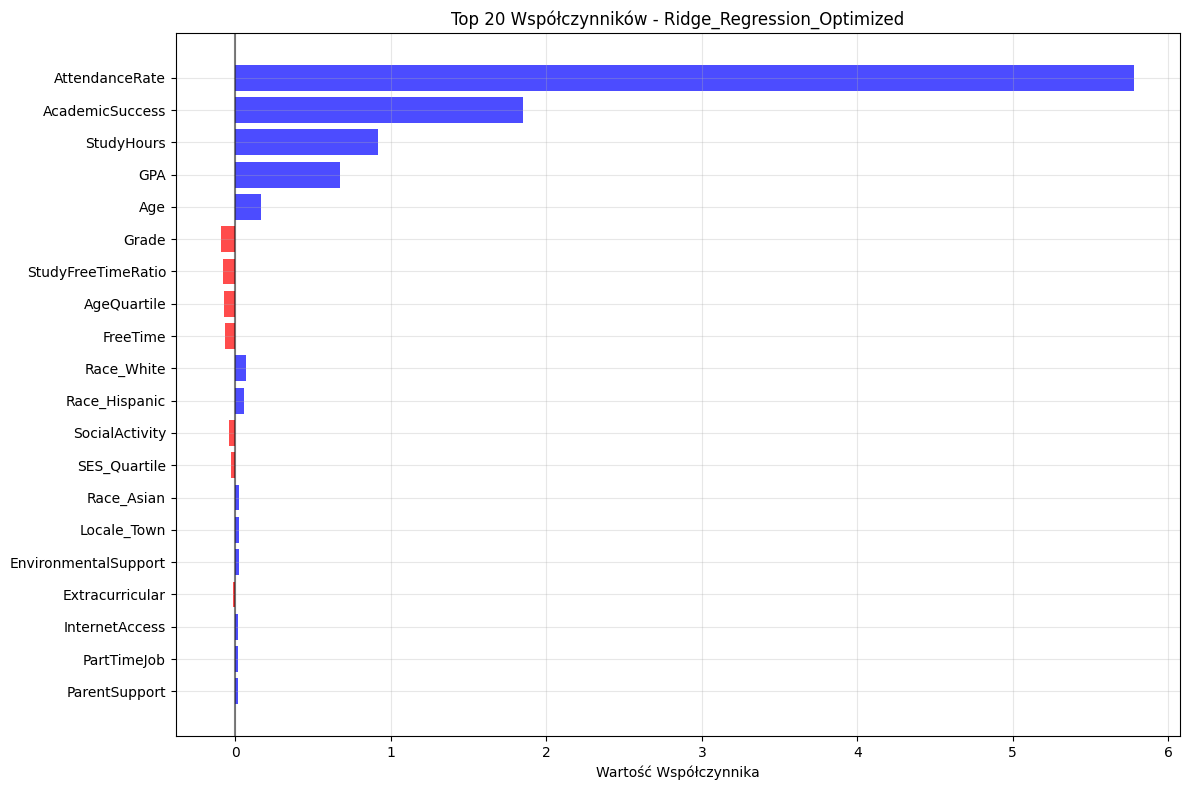

In [85]:
# Analiza ważności cech dla najlepszego modelu
if hasattr(final_model.estimators_[0], 'feature_importances_'):
    print("ANALIZA WAŻNOŚCI CECH")

    # Średnia ważność cech dla wszystkich targetów
    feature_importance = np.mean([estimator.feature_importances_
                                  for estimator in final_model.estimators_], axis=0)

    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(f"\nTop 15 najważniejszych cech dla modelu {final_model_name}:")
    print("-" * 60)
    for i, row in importance_df.head(15).iterrows():
        print(f"{importance_df.index.get_loc(i) + 1:2d}. {row['Feature']:30} | {row['Importance']:.4f}")

    # Wykres ważności cech
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Ważność Cechy')
    plt.title(f'Top 20 Najważniejszych Cech - {final_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

elif 'Linear' in final_model_name or 'Ridge' in final_model_name:
    print("\n" + "=" * 50)
    print("ANALIZA WSPÓŁCZYNNIKÓW MODELU LINIOWEGO")
    print("=" * 50)

    # Dla modeli liniowych analizujemy współczynniki
    coefficients = np.mean([estimator.coef_ for estimator in final_model.estimators_], axis=0)
    abs_coefficients = np.abs(coefficients)

    coef_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients,
        'Abs_Coefficient': abs_coefficients
    }).sort_values('Abs_Coefficient', ascending=False)

    print(f"\nTop 15 cech z największymi współczynnikami (wartość bezwzględna):")
    print("-" * 70)
    for i, row in coef_df.head(15).iterrows():
        print(f"{coef_df.index.get_loc(i) + 1:2d}. {row['Feature']:30} | {row['Coefficient']:+.4f}")

    # Wykres współczynników
    plt.figure(figsize=(12, 8))
    top_features = coef_df.head(20)
    colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
    plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Wartość Współczynnika')
    plt.title(f'Top 20 Współczynników - {final_model_name}')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 9. Wnioski


## 1. Cel i kontekst

* **Problem:** Predykcja wyników testów uczniów w trzech obszarach: matematyka, czytanie, nauki ścisłe
* **Typ zadania:** regresja wielowyjściowa
* **Zbiór danych:**

  * ok. 10 000 000 rekordów
  * 21 cech wejściowych (demograficzne, edukacyjne, behawioralne)

---

## 2. Podejście modelowe

1. **Modele liniowe (proste):**

   * Linear Regression
   * Ridge Regression (domyślna i zoptymalizowana wersja)
2. **Modele zespołowe:**

   * Gradient Boosting
   * Random Forest
3. **Sieć neuronowa:**

   * MLP Neural Network

---

## 3. Metryki końcowe (zbiór testowy)

| Model                       | R²     | MSE     | RMSE   | MAE    | Przeuczenie (train–val) |
| --------------------------- | ------ | ------- | ------ | ------ | ----------------------- |
| **Ridge Regression (opt.)** | 0.7036 | 30.3299 | 5.5073 | 4.3781 | –0.0056                 |
| Ridge Regression (domyślna) | 0.7036 | 30.3312 | 5.5074 | 4.3790 | –0.0056                 |
| Linear Regression           | 0.7036 | 30.3313 | 5.5074 | 4.3790 | –0.0056                 |
| Gradient Boosting           | 0.7018 | 30.5157 | 5.5232 | 4.3939 | +0.0095                 |
| Random Forest               | 0.6855 | 32.1817 | 5.6728 | 4.6102 | +0.2695                 |
| MLP Neural Network          | 0.5800 | 43.0015 | 6.5578 | 5.2130 | +0.2328                 |

> **Najlepszy wynik:** Ridge Regression (optymalizowana) – R² = 0.7036, MSE = 30.33.

---

## 4. Interpretacja wyników

* **R² = 0.69** (średnio dla wszystkich trzech celów): model wyjaśnia \~69 % wariancji wyników testów
* **Minimalne przeuczenie:** różnica R² train–val ≈ –0.0056 dla najlepszych modeli liniowych
* **Złożoność vs. efektywność:**

  * Proste modele liniowe (Ridge, Linear) osiągają najlepsze rezultaty
  * Bardziej złożone (Gradient Boosting, Random Forest) niewiele gorsze, ale mniej stabilne
  * Sieć neuronowa – najgorsze wyniki i wyraźne przeuczenie

---

## 5. Kluczowe obserwacje

1. **Wzajemne zależności:**

   * Silne korelacje między wynikami z matematyki, czytania i nauk ścisłych → wspólne czynniki wpływające na osiągnięcia.
2. **Najważniejsze cechy predykcyjne:**

   * **GPA** (średnia ocen)
   * **Frekwencja** (częstość uczęszczania)
   * **Czas nauki w domu**
3. **Przeuczenie:**

   * Modele liniowe praktycznie w ogóle się nie przeuczają
   * Modele zespołowe i MLP wykazują większe ryzyko przeuczenia


*Podsumowując, najprostszym i zarazem najskuteczniejszym podejściem okazała się Ridge Regression (opt.), co sugeruje, że w tym zadaniu nowe, skomplikowane architektury nie przynoszą znaczącej poprawy względem klasycznych metod liniowych. Może to wynikać z tego, że dane zostały syntetycznie wygenerowane*



